In [301]:
from Prob_game.risky_bomb_opt import *
from Prob_game.risky_bomb_stats import *

In [68]:
from tqdm import tqdm

In [285]:
class nn_evolution(object):
    
    def __init__(self,
                 count,
                 probs,
                 change_bomb  = "T",
                 n_play = 10,
                 n_pop = 10, 
                 elitism = 0.2, 
                 n_gen = 5, 
                 loser_percent = 0.2,
                 # NN parameters
                 n_input = 5, 
                 n_hidden = 5, 
                 n_output = 1, 
                 add_input = ["mean_guess", "mean_p", "last_3_p_mean", "last_3_p_mean"],
                 **kwargs
                ):
        
        self.count = count
        self.probs = probs
        self.change_bomb = change_bomb
        self.n_play = n_play
        self.n_pop = n_pop
        self.elitism = elitism
        self.n_gen = n_gen
        self.loser_percent = loser_percent
        # NN
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.add_input = add_input
        
        self.evolution_df = pd.DataFrame()
        self.evolution_results = pd.DataFrame()
        
        self.best_results_all = pd.DataFrame()
        
        # Weights
        self.best_w_input = None
        self.best_w_output = None
        
    # Evolve nn functions
    def evolve(self,**kwargs):
        
        # Initiate the output table
        df = pd.DataFrame(columns = ["ID", "w_input", "w_output", "score", "Sum_score","Mean_guess"])
        
        for j in tqdm(range(0, self.n_gen)):

            for i in range(0, self.n_pop):
                opt_inp = Risky_bomb_opt(count = self.count, 
                                         probs = self.probs, 
                                         change_bomb = self.change_bomb,
                                         a = kwargs.get('a'),
                                         peak = kwargs.get('peak'),
                                         smooth = kwargs.get('smooth'),
                                         n =  kwargs.get('n'),
                                         po =  kwargs.get('po'),
                                         df =  kwargs.get('df'))
                if j == 0:
                    out_opt = opt_inp.nn_opt(n_input = self.n_input, 
                                             n_hidden = self.n_hidden, 
                                             n_output = self.n_output, 
                                             add_input = self.add_input )
                else:
                     out_opt = opt_inp.nn_opt(n_input = self.n_input, 
                                             n_hidden = self.n_hidden, 
                                             n_output = self.n_output, 
                                             add_input = self.add_input,
                                             w_input = list(df_new["w_input"][i]), 
                                             w_output = list(df_new["w_output"][i]))               


                df = df.append({'Generation': j,
                                'ID': i, 
                                "w_input": opt_inp.w_input, 
                                "w_output": opt_inp.w_output, 
                                "score": int(sum(out_opt["payment"])/len(out_opt["payment"])),
                                "Sum_score": int(sum(out_opt["payment"])),
                                "Mean_guess": int(sum(out_opt["guesses"])/len(out_opt["guesses"]))
                                }, ignore_index=True)

            # Elitism
            elitism_n = int(np.floor(self.elitism * self.n_pop))
            loser_n = int(np.floor(self.loser_percent * self.n_pop))
            df_c_gen = df[df['Generation'] == j].reset_index()
            df_c_gen["score"] = df_c_gen.score.astype(float)
            elits = df_c_gen.nlargest(elitism_n,"score")
            elits = elits[["w_input", "w_output"]]
            losers = df_c_gen.nsmallest(loser_n,"score")
            losers = losers[["w_input", "w_output"]]



            df_parents = pd.DataFrame(columns = ["w_input", "w_output"])
            df_parents = df_parents.append(elits, ignore_index = True)
            df_parents = df_parents.append(losers, ignore_index = True)


            # Breed
            n_parents = df_parents.shape[0]
            n_children = self.n_pop - n_parents
            df_children = pd.DataFrame(columns = ["w_input", "w_output"])
            for i in range(0, n_children):
                # w_input
                p1,p2 = random.randint(0, n_parents-1), random.randint(0, n_parents-1)
                w_1 = random.uniform(0, 1)
                w_2 = 1 - w_1
                w_input_new = df_parents["w_input"][p1] * w_1 + df_parents["w_input"][p2] * w_2
                w_output_new = df_parents["w_output"][p1] * w_1 + df_parents["w_output"][p2] * w_2
                # Caps
                w_input_new[w_input_new > 1] = 1
                w_input_new[w_input_new < -1] = -1
                w_output_new[w_output_new > 1] = 1
                w_output_new[w_output_new < -1] = -1 

                df_children = df_children.append({
                                "w_input": w_input_new, 
                                "w_output": w_output_new}, ignore_index=True)

            # Mutate 
            for i in range(0, n_children - 1):
                # w_input
                p1 = random.randint(0, n_children - 1)
                m_f = random.uniform(-0.25, 0.25)
                w_input_new = df_children["w_input"][p1] + m_f
                w_output_new = df_children["w_output"][p1] + m_f
                # Caps
                w_input_new[w_input_new > 1] = 1
                w_input_new[w_input_new < -1] = -1
                w_output_new[w_output_new > 1] = 1
                w_output_new[w_output_new < -1] = -1 

                df_children["w_input"][p1] = w_input_new
                df_children["w_output"][p1] = w_output_new

            df_new =  pd.DataFrame(columns = ["w_input", "w_output"])
            df_new = df_new.append(df_parents, ignore_index = True)
            df_new = df_new.append(df_children, ignore_index = True)
        
        id_help = []
        for i in range(0, len(df["ID"])):
            id_help.append(str(sum(np.dot(sum(df.w_output[i]),df.w_input[i]))))
        df['ID2'] = pd.factorize(id_help)[0]
        
        self.evolution_df = df
    
    def summary_results(self):
        result = pd.DataFrame()
        result['sum'] = self.evolution_df.groupby('Generation')['score'].sum()
        result['avg'] = self.evolution_df.groupby('Generation')['score'].sum()/self.evolution_df.groupby('Generation')['score'].count()
        result['max'] = self.evolution_df.groupby('Generation')['score'].max()
        result['min'] = self.evolution_df.groupby('Generation')['score'].min()
        self.evolution_results = result
        return(result)
    
    def plot_improvement(self, plot_type ="avg"):     
        # Plotting
        plt.plot(range(1,len(self.evolution_results['sum']) + 1), self.evolution_results[plot_type] , color = '#001871')
        plt.xlabel('Generation', fontsize=15)
        plt.ylabel('Score', fontsize=15)
        plt.title('Improvement in the model by nn generations' , fontsize=20)
        plt.rcParams["figure.figsize"] = [10,7]

        plt.show() 
    
    def select_best_nn(self, gen_cons = 'all', variable = "Avg_avg_scores", min_gen = 5 ):
        
        # All stats
        result = pd.DataFrame()
        result["Sum_avg_scores"] = self.evolution_df.groupby('ID2')['score'].sum()
        result["Sum_sum_scores"] = self.evolution_df.groupby('ID2')['Sum_score'].sum()
        result["Sum_Mean_guess"] = self.evolution_df.groupby('ID2')['Mean_guess'].sum()
        result["Count_Gen"] = self.evolution_df.groupby('ID2')['score'].count()
        #
        result["Avg_avg_scores"] = result["Sum_avg_scores"] / result["Count_Gen"]
        result["Avg_sum_scores"] = result["Sum_sum_scores"] / result["Count_Gen"]
        result["Avg_Mean_guess"] = result["Sum_Mean_guess"] / result["Count_Gen"]
        result["Last_generation"] = self.evolution_df.groupby('ID2')['Generation'].max()
        
        un_df =  self.evolution_df.groupby('ID2').first()
        un_df = un_df[['w_input','w_output']]
        result = pd.merge(result, un_df, left_on = 'ID2', right_on = 'ID2').reset_index()
       
        # Filter and sort
        result = result[result["Count_Gen"] >= min_gen]
        result = result.sort_values(by = variable, ascending = False).reset_index()
        
        self.best_results_all = result
        
        if gen_cons == 'all':
            pass
        else: 
            result = result[result["Last_generation"] == self.n_gen - 1]
            
        self.best_w_input = result["w_input"][0]
        self.best_w_output = result["w_output"][0]
           
        return({'w_input': self.best_w_input, 'w_output': self.best_w_output})
        

In [286]:
a = nn_evolution(count = 99, probs = "skewnorm"  , n_play = 50, n_pop = 30,  n_gen = 40 , elitism = 0.6 , loser_percent = 0)

100%|██████████| 40/40 [01:05<00:00,  1.84s/it]


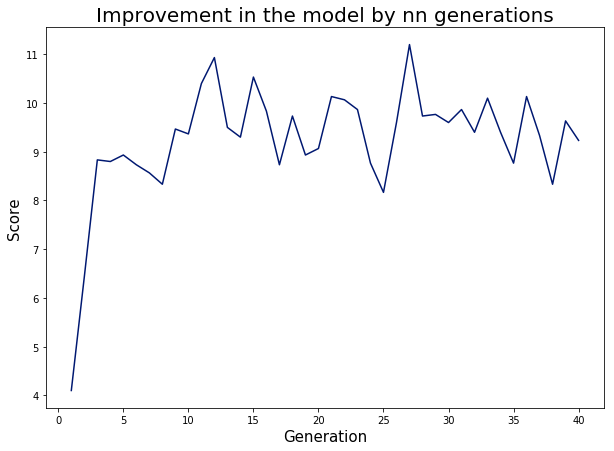

In [287]:
a.evolve(a = 10)
a.summary_results()
a.plot_improvement()

In [290]:
c = a.select_best_nn()

In [291]:
c["w_input"]

array([[-0.39820322,  0.2784529 ,  0.18078793,  0.58316446, -0.12367002],
       [ 0.04484421,  0.49837715,  0.34406081,  0.16298001,  0.28712096],
       [-0.68186943, -0.57635157,  0.69724986, -0.0047151 ,  0.01296372],
       [-0.1059998 , -0.45774872, -0.12628744, -0.77769471,  0.26000056],
       [ 0.50870261, -0.53624074,  0.44885109, -0.51246237,  0.34348054]])

In [295]:
best_nn = Risky_bomb_opt(count = 99, probs = "skewnorm", a= 10, n_play = 50, change_bomb = "T")
s = best_nn.nn_opt(n_input = 5, n_hidden = 5, n_output = 1, add_input = ["mean_guess", "mean_p", "last_3_p_mean", "last_p"],
              w_input = list(c["w_input"]) , w_output= list(c["w_output"]))

In [298]:
s

,payment,guesses,bomb,mean_guess,std_guess,mean_p,std_p,last_3_p_mean
0,11,11,39,11.000000,0.000000,11.000000,0.000000,11.000000
1,14,14,24,12.500000,1.500000,12.500000,1.500000,12.500000
2,0,17,15,14.000000,2.449490,8.333333,6.018490,8.333333
3,17,17,20,14.750000,2.487469,10.500000,6.422616,10.333333
4,0,17,7,15.200000,2.400000,8.400000,7.116179,5.666667
5,17,17,31,15.500000,2.291288,9.833333,7.243771,11.333333
6,18,18,19,15.857143,2.294625,11.000000,7.289915,11.666667
7,18,18,38,16.125000,2.260393,11.875000,7.201345,17.666667
8,19,19,28,16.444444,2.314741,12.666667,7.149204,18.333333
9,0,19,8,16.700000,2.325941,11.400000,7.774317,12.333333


In [299]:
s['payment'].sum()/s['payment'].count()

11.76

In [302]:
opt = Risky_bomb_stats(count = 99, probs = "skewnorm", a = 10 ,iteration= 500, m_iteration = 50, change_bomb = "T")

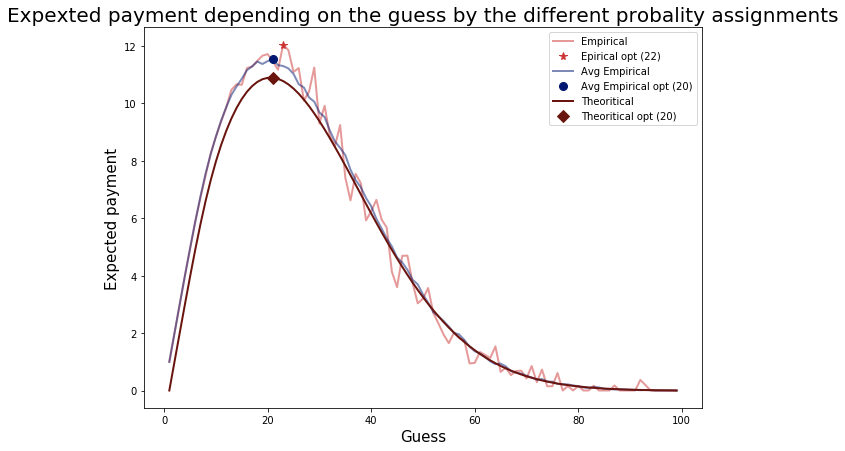

In [303]:
opt.plot_all()

In [304]:
opt.optimum()

20

In [305]:
opt.

array([  1.37417279e-04,   5.83422743e-04,   1.81331921e-03,
         4.70807890e-03,   1.05588552e-02,   2.07963936e-02,
         3.64724030e-02,   5.77747178e-02,   8.39212644e-02,
         1.13514677e-01,   1.45092505e-01,   1.77524502e-01,
         2.10115652e-01,   2.42506249e-01,   2.74524803e-01,
         3.06082511e-01,   3.37120707e-01,   3.67591098e-01,
         3.97450004e-01,   4.26657116e-01,   4.55175366e-01,
         4.82971014e-01,   5.10013733e-01,   5.36276688e-01,
         5.61736575e-01,   5.86373642e-01,   6.10171683e-01,
         6.33118003e-01,   6.55203367e-01,   6.76421919e-01,
         6.96771082e-01,   7.16251444e-01,   7.34866621e-01,
         7.52623104e-01,   7.69530098e-01,   7.85599344e-01,
         8.00844935e-01,   8.15283123e-01,   8.28932120e-01,
         8.41811901e-01,   8.53943998e-01,   8.65351300e-01,
         8.76057851e-01,   8.86088660e-01,   8.95469506e-01,
         9.04226754e-01,   9.12387182e-01,   9.19977815e-01,
         9.27025761e-01,

In [250]:
a.best_results_all["w_input"][0]

array([[-0.02637111, -0.87184043, -0.02621909, -0.09503136,  0.81833691],
       [ 0.31197052,  0.93530274, -0.70309873,  0.90699797,  0.09862573],
       [ 0.40648182,  0.46097058, -0.95753656, -0.66604777,  0.22747088],
       [-0.84799912,  0.37911927,  0.62679324, -0.76068817, -0.45497493],
       [ 0.80392993,  0.08918241,  0.44686646, -0.45052278,  0.60349122]])

In [183]:
b = a.evolution_df

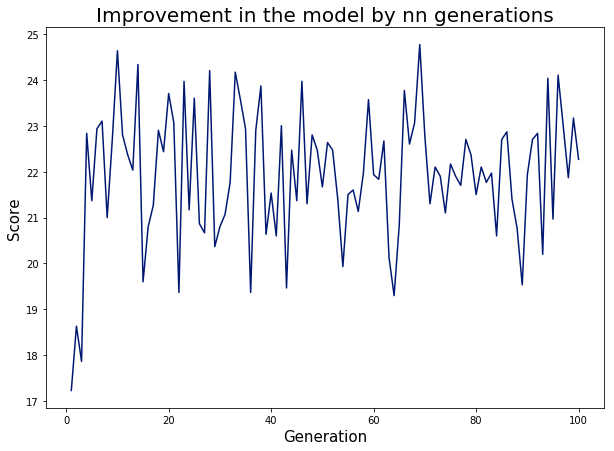

In [86]:
a.plot_improvement()

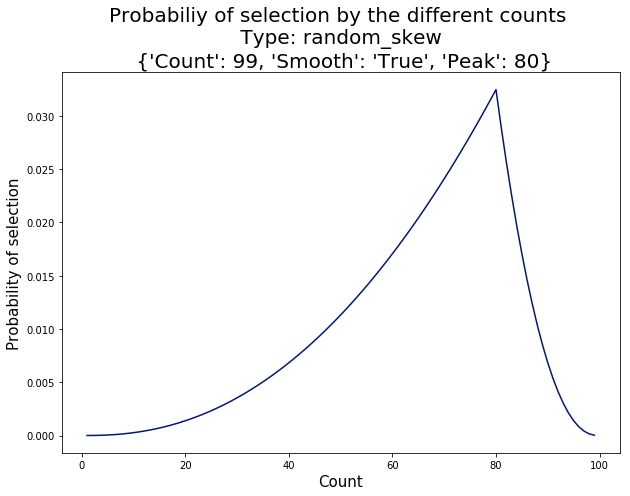

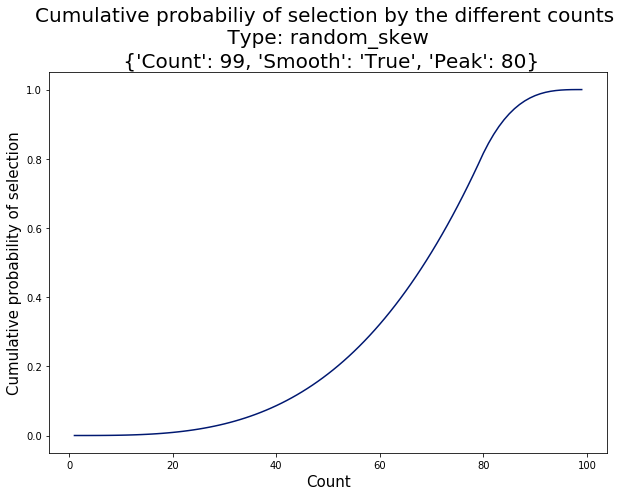

DescribeResult(nobs=99, minmax=(0.0, 0.032457682596953141), mean=0.010101010101010102, variance=9.3448237675557787e-05, skewness=0.7421986058272273, kurtosis=-0.7044351290400952)

In [307]:
a = Prob_stats(count= 99, probs = "random_skew", peak = 80, smooth = "True")
a.prob_plot()
a.cum_prob_plot()
a.stats()

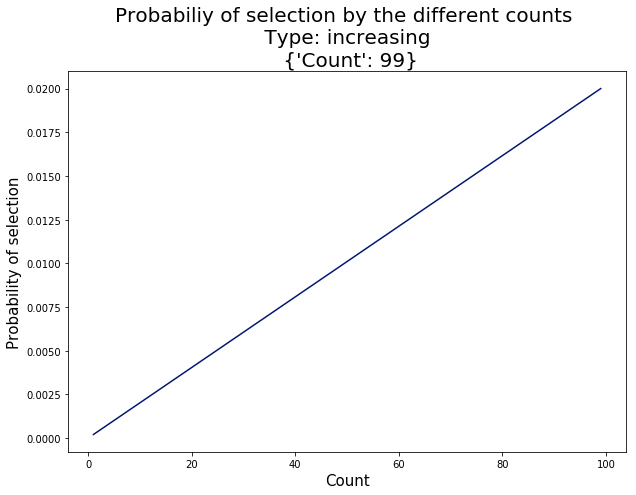

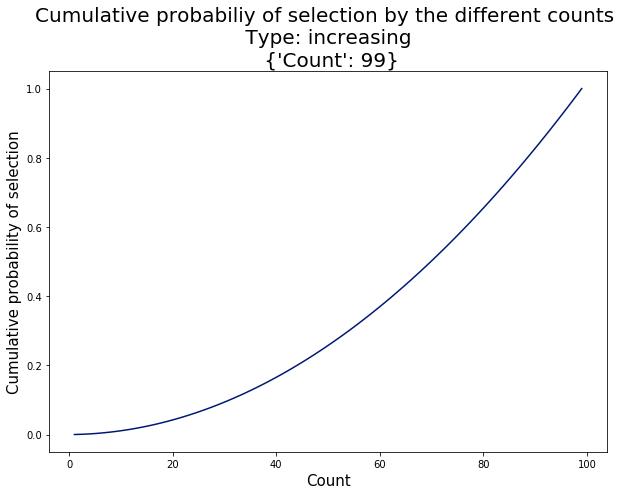

DescribeResult(nobs=99, minmax=(0.00020202020202020202, 0.02), mean=0.010101010101010102, variance=3.3670033670033675e-05, skewness=-4.112966706354912e-16, kurtosis=-1.2002448979591842)

In [309]:
a = Prob_stats(count= 99, probs = "increasing")
a.prob_plot()
a.cum_prob_plot()
a.stats()